In [1]:
# Fangjun Hu

# Preamble
import numpy as np
import math
import scipy
import random
import matplotlib.pyplot as plt
import scipy.linalg as la

from scipy.integrate import ode
from scipy.integrate import odeint
from scipy.linalg import expm, logm, sinm, cosm, svd

from numpy.linalg import matrix_rank
from sklearn import svm
from sklearn import linear_model
from copy import deepcopy

# Import qutip
from qutip import *
from qutip.expect import expect_rho_vec

import time

# Font
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)


In [2]:
params = {
    'text.usetex' : True,
    'font.family' : 'Computer Modern Roman',
    'axes.labelsize': '16',
    'axes.titlesize':'16',
    'xtick.labelsize':'20',
    'ytick.labelsize':'20',
    'lines.linewidth' : 1,
    'legend.fontsize': '14',
    'xtick.major.size': 6.,
    'ytick.major.size': 6.,
    }
plt.rcParams.update(params) 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#2ca02c","#8c564b", "#bcbd22", "#d62728",  
                                                    "#9467bd","#e377c2", "#7f7f7f", "#17becf", "#ff7f0e"])


In [3]:
params = {'axes.labelsize': '50',
    'axes.titlesize':'50',
    'xtick.labelsize':'50',
    'ytick.labelsize':'50',
    'lines.linewidth' : 4,
    'legend.fontsize': '40',
    'xtick.major.size': 40.,
    'ytick.major.size': 40.,
    'xtick.minor.size': 20.,
    'ytick.minor.size': 20.,
    }
plt.rcParams.update(params) 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#2ca02c","#8c564b", "#bcbd22", "#d62728",  
                                                    "#9467bd","#e377c2", "#7f7f7f", "#17becf", "#ff7f0e"])

Navigation: <a id='top' />

<a href=#PrelimQuantObj>1. Preliminary quantum function</a>

<a href=#SptmQtmChnl>2. Varying $\gamma_1$</a>

<a href=#Vary_tau>3. Varying $\tau$</a>

# 1. Preliminary quantum function <a id='PrelimQuantObj' />
<a href=#top>Return to top</a>

In [4]:
def Classical_Entropy(eig_list):
    Entropy = 0
    for i in range(len(eig_list)): 
        if eig_list[i] !=0: 
            Entropy = Entropy - eig_list[i] * np.log(eig_list[i])/np.log(2)
    return Entropy

def sigmoid(x):
    return 1/(1+np.exp(-x))


In [5]:
N_system  = 4
N_ancilla = 2
N_qubits  = N_system + N_ancilla

X_op = []  # Defined on all qubits
for i in range(N_qubits):
    X = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            X = tensor(X, sigmax())
        else: 
            X = tensor(X, qeye(2))
    X = X.ptrace(range(1, N_qubits + 1))
    X_op.append(X)

Z_op = []  # Defined on all qubits
for i in range(N_qubits):
    Z = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            Z = tensor(Z, sigmaz())
        else: 
            Z = tensor(Z, qeye(2))
    Z = Z.ptrace(range(1, N_qubits + 1))
    Z_op.append(Z)
    
C_op = []  # Defined on all qubits
for i in range(N_qubits):
    C = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            C = tensor(C, create(2))
        else: 
            C = tensor(C, qeye(2))
    C = C.ptrace(range(1, N_qubits + 1))
    C_op.append(C)
    
D_op = []  # Defined on all qubits
for i in range(N_qubits):
    D = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            D = tensor(D, destroy(2))
        else: 
            D = tensor(D, qeye(2))
    D = D.ptrace(range(1, N_qubits + 1))
    D_op.append(D)
    
G_op = []  # Defined on all qubits
for i in range(N_qubits):
    G = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            G = tensor(G, (1+sigmaz())/2)
        else: 
            G = tensor(G, qeye(2))
    G = G.ptrace(range(1, N_qubits + 1))
    G_op.append(G)
    
E_op = []  # Defined on all qubits
for i in range(N_qubits):
    E = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            E = tensor(E, (1-sigmaz())/2)
        else: 
            E = tensor(E, qeye(2))
    E = E.ptrace(range(1, N_qubits + 1))
    E_op.append(E)

        
len(X_op), len(Z_op), len(D_op), len(G_op)


(6, 6, 6, 6)

In [6]:
destroy(2), sigmaz()

(Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
 Qobj data =
 [[0. 1.]
  [0. 0.]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.]
  [ 0. -1.]])

# 2. Varying $\gamma_1$ <a id='SptmQtmChnl' />
<a href=#top>Return to top</a>

In [7]:
ψg = basis(2, 0)
ρg = ψg*ψg.dag()

ψe = basis(2, 1)
ρe = ψe*ψe.dag()

ρ0 = qeye(1)
for i in range(N_system): 
    ρ0 = tensor(ρ0, ρg)
ρ0 = ρ0.ptrace(range(1, N_system+1)) # Reduce dims

ρS  = ρ0
ρSE = ρS
for r in range(N_ancilla):
    ρSE = tensor(ρSE, ρg)


In [8]:
τ = 1
tlist = np.linspace(0.0, τ, 100)

rseed = 17462 # seed for generator so get repeateable CE string
rs = np.random.RandomState(seed = rseed) # random number generator

hx0_vec = 1.0 + 0.3*rs.randn(N_qubits)
# hx1_vec = 0.5 + 0.0*rs.randn(N_qubits)
hz0_vec = 0.0 + 0.0*rs.randn(N_qubits)
hz1_vec = 1.0 + 0.3*rs.randn(N_qubits)

# Complete graph
J_graph = np.zeros((N_qubits, N_qubits))
for i in range(N_qubits): 
    for j in range(N_qubits): 
        if i < j: J_graph[i, j] = 1
            
J_mat = 0 + 1.0*rs.rand(N_qubits, N_qubits)
J_mat = J_mat * J_graph

γ1_vec = 1e-2 + 0.0*np.random.randn(N_qubits)
γ1_rdm = 2*np.random.rand(N_qubits)-1
γ2_vec = 0.0 + 0.0*np.random.randn(N_qubits)
print(f'J_mat = \n{J_mat},\nhx0_vec = \n {hx0_vec},\nhz0_vec = \n {hz0_vec},\nhz1_vec = \n {hz1_vec},\nγ_vec = \n {γ1_vec},\nγ1_rdm = {γ1_rdm}. ')

H0 = 0
for i in range(N_qubits):
    H0 = H0 + hx0_vec[i] * X_op[i]
# for i in range(N_qubits):
#     H0 = H0 + hz0_vec[i] * Z_op[i]
for i in range(N_qubits):
    for j in range(N_qubits):
        H0 = H0 + J_mat[i, j] * Z_op[i] * Z_op[j]

H1 = 0
# for i in range(N_qubits):
#     H1 = H1 + hx1_vec[i] * X_op[i]
for i in range(N_qubits):
    H1 = H1 + hz1_vec[i] * Z_op[i]

def Hamiltonian_Encoding(u, H0, H1): 
    return H0 + u*H1

Pauli_Basis  = [qeye(2), sigmax(), sigmay(), sigmaz()]
Pauli_String = []
for i in range(4**N_system): 
    string = np.base_repr(i, base=4)
    string = '0'*(N_system-len(string))+string
    tsr = qeye(1)
    for j in range(N_system): 
        tsr = tensor(tsr, Pauli_Basis[int(string[j])])
    tsr = tsr.ptrace(range(1, N_system+1))
    Pauli_String.append(tsr)

c_ops = []
for i in range(N_qubits):
    c_ops.append(np.sqrt(γ1_vec[i]) * D_op[i])
#     c_ops.append(np.sqrt(γ2_vec[i]) * G_op[i])


J_mat = 
[[0.         0.74393229 0.43883853 0.49543245 0.96855876 0.98246317]
 [0.         0.         0.06738902 0.28208496 0.25618152 0.51159754]
 [0.         0.         0.         0.02777382 0.03569733 0.51026408]
 [0.         0.         0.         0.         0.57702502 0.08078052]
 [0.         0.         0.         0.         0.         0.19039596]
 [0.         0.         0.         0.         0.         0.        ]],
hx0_vec = 
 [1.31762211 0.63126002 0.91341166 0.92551197 1.05967067 0.97239387],
hz0_vec = 
 [0. 0. 0. 0. 0. 0.],
hz1_vec = 
 [1.0139355  0.95361189 1.38327525 1.05268228 1.09867245 0.49455003],
γ_vec = 
 [0.01 0.01 0.01 0.01 0.01 0.01],
γ1_rdm = [ 0.40896269 -0.94600133  0.39595086 -0.74508306  0.29629044 -0.47310416]. 


In [9]:
np.min(γ1_rdm)

-0.9460013259852988

In [10]:
γ1_val_list = np.linspace(0, 1, 11)
γ1_val_list = np.hstack(( np.array([0]), np.logspace(-3, 1, 11) ))
γ1_val_list


array([0.00000000e+00, 1.00000000e-03, 2.51188643e-03, 6.30957344e-03,
       1.58489319e-02, 3.98107171e-02, 1.00000000e-01, 2.51188643e-01,
       6.30957344e-01, 1.58489319e+00, 3.98107171e+00, 1.00000000e+01])

In [11]:
sT = time.time()

Trans_list = []
norm_list = []
half_life_list = []

for t in range(len(γ1_val_list)):
    
    γ1 = γ1_val_list[t]
    γ1_vec = γ1 + 0.0*np.random.randn(N_qubits)
    
    c_ops = []
    for i in range(N_qubits):
        c_ops.append(np.sqrt(γ1_vec[i]) * D_op[i])
#         c_ops.append(np.sqrt(γ2_vec[i]) * G_op[i])

    Trans = np.zeros((4**(N_system), 4**(N_system)))

    for i in range(4**(N_system)): 

        ρS = Pauli_String[i]
        ρSE = ρS
        for r in range(N_ancilla):
            ρSE = tensor(ρSE, ρg)
        
#         ρSE = U0 * ρSE * U0D
        output = mesolve(H0, ρSE, tlist, c_ops)
        ρSE = output.states[-1]

        ρS = ρSE.ptrace(range(N_system))

        for j in range(4**(N_system)): 
            Trans[j, i] = np.real((np.array(ρS) @ np.array(Pauli_String[j])).trace())/2**(N_system)

    norm = np.sort(np.abs(la.eigvals(Trans)))
    half_life = np.log(0.5)/np.log(norm[-2])

    Trans_list.append(Trans)
    norm_list.append(norm)
    half_life_list.append(half_life)

    print(f'γ1 = {np.round(γ1, 4)}, time = {np.round(time.time() - sT, 3)} s.')

print(f'Total time = {np.round(time.time() - sT, 3)} s.') # ρFP


γ1 = 0.0, time = 17.058 s.
γ1 = 0.001, time = 37.654 s.
γ1 = 0.0025, time = 59.248 s.
γ1 = 0.0063, time = 80.426 s.
γ1 = 0.0158, time = 102.496 s.
γ1 = 0.0398, time = 123.253 s.
γ1 = 0.1, time = 144.084 s.
γ1 = 0.2512, time = 166.061 s.
γ1 = 0.631, time = 186.812 s.
γ1 = 1.5849, time = 207.407 s.
γ1 = 3.9811, time = 228.872 s.
γ1 = 10.0, time = 255.104 s.
Total time = 255.104 s.


In [12]:
-1.369487754444573/np.log(0.5)


1.975753191895348

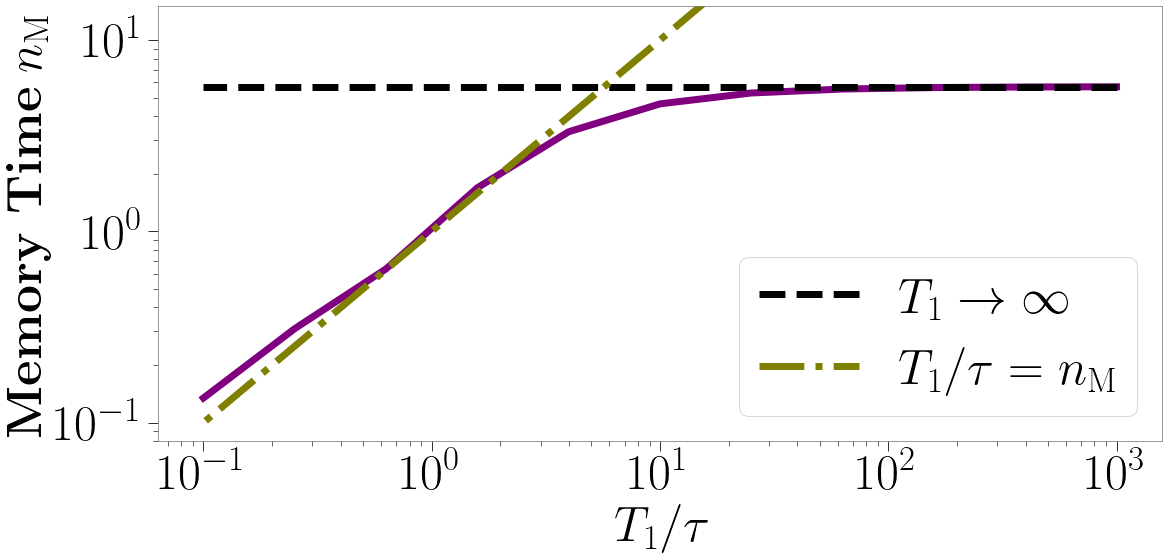

In [16]:
params = {'axes.labelsize': '50',
    'axes.titlesize':'50',
    'xtick.labelsize':'50',
    'ytick.labelsize':'50',
    'lines.linewidth' : 7,
    'legend.fontsize': '40',
    'xtick.major.size': 10.,
    'ytick.major.size': 10.,
    'xtick.minor.size': 5.,
    'ytick.minor.size': 5.,
    }
plt.rcParams.update(params) 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#2ca02c","#8c564b", "#bcbd22", "#d62728",  
                                                    "#9467bd","#e377c2", "#7f7f7f", "#17becf", "#ff7f0e"])

fig, axes = plt.subplots(1, 1, figsize=(18, 8))

ax = axes
ax.plot(1/(γ1_val_list[1:]*τ), half_life_list[1:], color = 'purple')
ax.plot(1/(γ1_val_list[1:]*τ), [half_life_list[0]]*len(γ1_val_list[1:]), color = 'black', ls = '--', label=r'$T_1 \to \infty$')
ax.plot(1/(γ1_val_list[1:]*τ), 1/(γ1_val_list[1:]*τ), color = 'olive', ls = '-.', alpha=1, label=r'$T_1/\tau = n_\mathrm{M}$')
ax.set_ylim([8e-2, 1.5e1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$T_1/\tau$')
ax.set_ylabel(r'\textbf{Memory Time} $n_\mathrm{M}$')
# ax.set_title(r'$L=4+2$, $H_0$-\textbf{parameter} $h,J \sim 1$ \textbf{and} $\tau=0.5$')
ax.legend(fontsize = 50)

ax.spines[['bottom', 'top', 'right', 'left']].set_color('gray')

# 3. Varying $\tau$ <a id='Vary_tau' />
<a href=#top>Return to top</a>

In [278]:
rseed = 17462 # seed for generator so get repeateable CE string
rs = np.random.RandomState(seed = rseed) # random number generator

hx0_vec = 1.0 + 0.3*rs.randn(N_qubits)
# hx1_vec = 0.5 + 0.0*rs.randn(N_qubits)
hz0_vec = 0.0 + 0.0*rs.randn(N_qubits)
hz1_vec = 1.0 + 0.3*rs.randn(N_qubits)

# Complete graph
J_graph = np.zeros((N_qubits, N_qubits))
for i in range(N_qubits): 
    for j in range(N_qubits): 
        if i < j: J_graph[i, j] = 1
            
J_mat = 0 + 1.0*rs.rand(N_qubits, N_qubits)
J_mat = J_mat * J_graph

γ_vec = 0.0 + 0.0*np.random.randn(N_qubits)
print(f'J_mat = \n{J_mat},\nhx0_vec = \n {hx0_vec},\nhz0_vec = \n {hz0_vec},\nhz1_vec = \n {hz1_vec},\nγ_vec = \n {γ_vec}. ')

H0 = 0
for i in range(N_qubits):
    H0 = H0 + hx0_vec[i] * X_op[i]
# for i in range(N_qubits):
#     H0 = H0 + hz0_vec[i] * Z_op[i]
for i in range(N_qubits):
    for j in range(N_qubits):
        H0 = H0 + J_mat[i, j] * Z_op[i] * Z_op[j]

H1 = 0
# for i in range(N_qubits):
#     H1 = H1 + hx1_vec[i] * X_op[i]
for i in range(N_qubits):
    H1 = H1 + hz1_vec[i] * Z_op[i]

def Hamiltonian_Encoding(u, H0, H1): 
    return H0 + u*H1


J_mat = 
[[0.         0.74393229 0.43883853 0.49543245 0.96855876 0.98246317]
 [0.         0.         0.06738902 0.28208496 0.25618152 0.51159754]
 [0.         0.         0.         0.02777382 0.03569733 0.51026408]
 [0.         0.         0.         0.         0.57702502 0.08078052]
 [0.         0.         0.         0.         0.         0.19039596]
 [0.         0.         0.         0.         0.         0.        ]],
hx0_vec = 
 [1.31762211 0.63126002 0.91341166 0.92551197 1.05967067 0.97239387],
hz0_vec = 
 [0. 0. 0. 0. 0. 0.],
hz1_vec = 
 [1.0139355  0.95361189 1.38327525 1.05268228 1.09867245 0.49455003],
γ_vec = 
 [0. 0. 0. 0. 0. 0.]. 


In [279]:
sT = time.time()

τ_list = [0, 0.1, 0.5, 1, 10]
Trans_list = []
half_life_list = []

for z in range(5):
    
    if (z+1)%20 == 0: 
        print(f'For {z+1}-th τ, elapsed time = {np.round(time.time() - sT, 3)} s.')
    τ = τ_list[z]
    
    U0  = (- 1j * τ * H0).expm()
    U0D = (+ 1j * τ * H0).expm()

    Pauli_Basis  = [qeye(2), sigmax(), sigmay(), sigmaz()]
    Pauli_String = []

    for i in range(4**N_system): 
        string = np.base_repr(i, base=4)
        string = '0'*(N_system-len(string))+string
        tsr = qeye(1)
        for j in range(N_system): 
            tsr = tensor(tsr, Pauli_Basis[int(string[j])])
        tsr = tsr.ptrace(range(1, N_system+1))
        Pauli_String.append(tsr)

    Trans = np.zeros((4**(N_system), 4**(N_system)))

    for i in range(4**(N_system)): 
        
        ρS = Pauli_String[i]
        ρSE = ρS
        for r in range(N_ancilla):
            ρSE = tensor(ρSE, ρg)
        ρSE = U0 * ρSE * U0D
        ρS = ρSE.ptrace(range(N_system))

        for j in range(4**(N_system)): 
            Trans[j, i] = np.real((np.array(ρS) @ np.array(Pauli_String[j])).trace())/2**(N_system)
            
    Trans_list.append(Trans)
    
    if z>0:
        norm_list = np.sort(np.abs(la.eigvals(Trans)))
        half_life = np.log(0.5)/np.log(norm_list[-2])
        half_life_list.append(1/half_life)

print(f'Total time = {np.round(time.time() - sT, 3)} s.') # ρFP


Total time = 9.461 s.


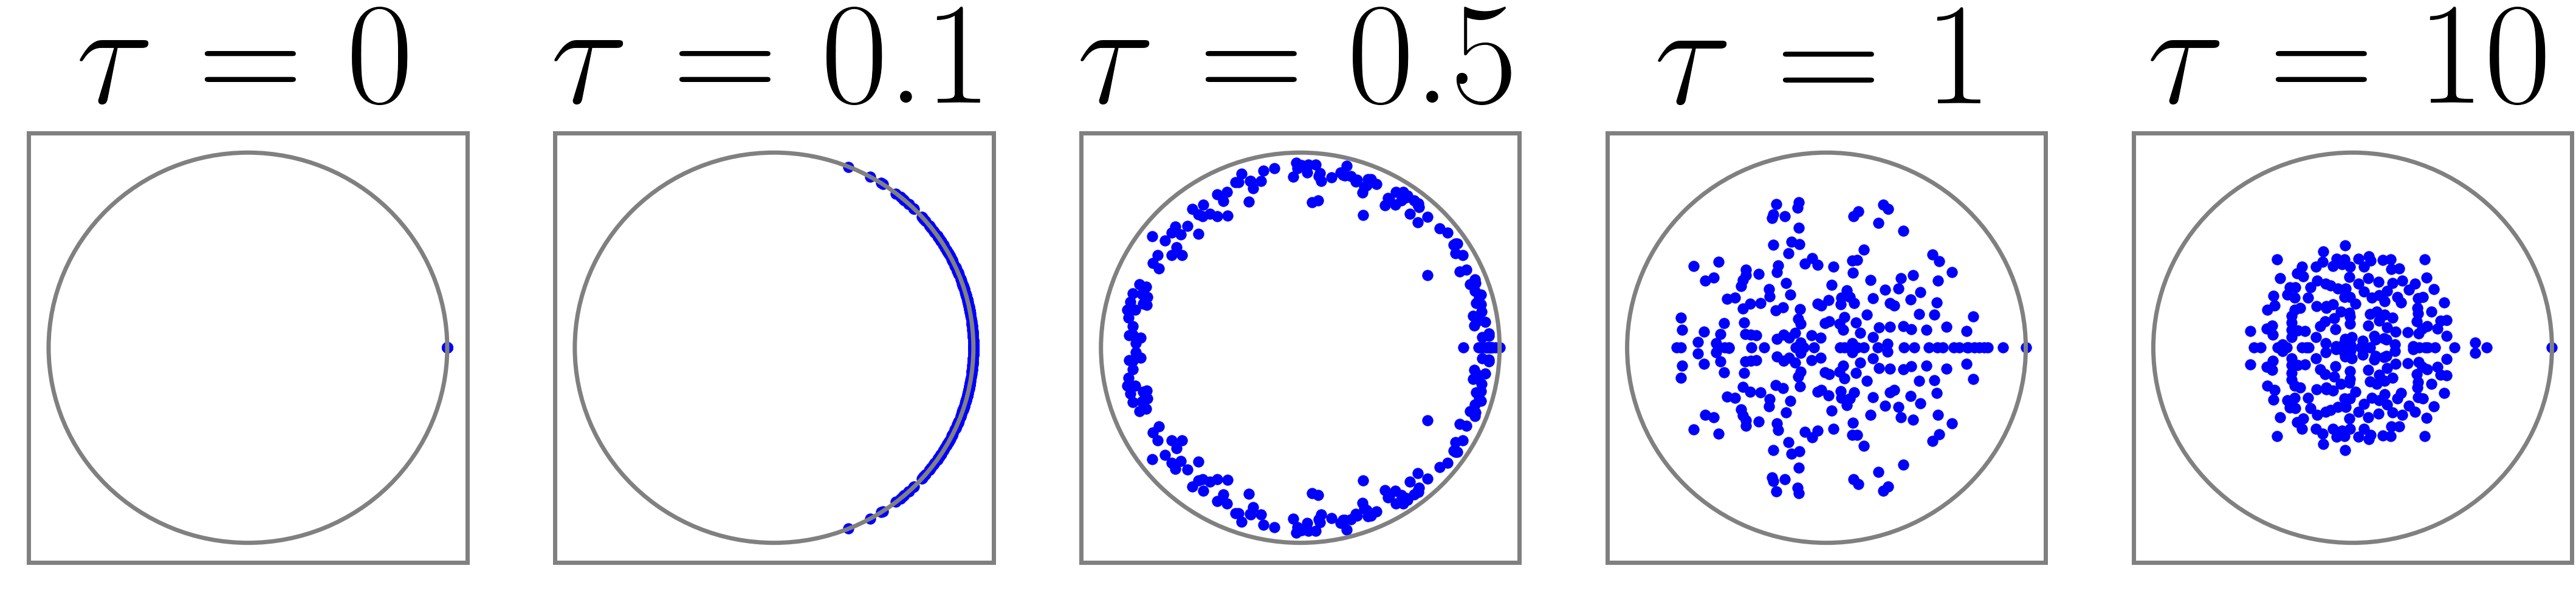

In [280]:
fig, axes = plt.subplots(1, 5, figsize=(15*5, 13))
for r in range(5):
    ax = axes[r]
    circ = plt.Circle((0, 0), radius=1, edgecolor='gray', facecolor='None', linewidth=7)
    ax.add_patch(circ)
    ax.scatter(np.real(la.eigvals(Trans_list[r])), np.imag(la.eigvals(Trans_list[r])), s=300, color='blue')
    plt.xticks([])
    ax.set_xticks([])
    plt.yticks([])
    ax.set_yticks([])
#     ax.legend(loc='upper right', fontsize=60)
    ax.set_title(rf'$\tau$ = {τ_list[r]}', fontsize=240)
    
    ax.spines[['bottom', 'top', 'right', 'left']].set_color('gray')
    ax.spines[['bottom', 'top', 'right', 'left']].set_linewidth(7)
    

In [142]:
sT = time.time()

# τ_list = np.linspace(0, 10, 101)
τ_list = np.logspace(-2, 2, 101)

Trans_list = []
half_life_list = []

for z in range(101):
    
    if (z+1)%20 == 0: 
        print(f'For {z+1}-th τ, elapsed time = {np.round(time.time() - sT, 3)} s.')
    τ = τ_list[z]
    
    U0  = (- 1j * τ * H0).expm()
    U0D = (+ 1j * τ * H0).expm()

    Trans = np.zeros((4**(N_system), 4**(N_system)))

    for i in range(4**(N_system)): 
        
        ρS = Pauli_String[i]
        ρSE = ρS
        for r in range(N_ancilla):
            ρSE = tensor(ρSE, ρg)
        ρSE = U0 * ρSE * U0D
        ρS = ρSE.ptrace(range(N_system))

        for j in range(4**(N_system)): 
            Trans[j, i] = np.real((np.array(ρS) @ np.array(Pauli_String[j])).trace())/2**(N_system)
            
    Trans_list.append(Trans)
    
    norm_list = np.sort(np.abs(la.eigvals(Trans)))
    half_life = np.log(0.5)/np.log(norm_list[-2])
    half_life_list.append(half_life)

print(f'Total time = {np.round(time.time() - sT, 3)} s.') # ρFP


In [21]:
τ_list[10:64]

array([0.02511886, 0.02754229, 0.03019952, 0.03311311, 0.03630781,
       0.03981072, 0.04365158, 0.04786301, 0.05248075, 0.05754399,
       0.06309573, 0.0691831 , 0.07585776, 0.08317638, 0.09120108,
       0.1       , 0.10964782, 0.12022644, 0.13182567, 0.14454398,
       0.15848932, 0.17378008, 0.19054607, 0.20892961, 0.22908677,
       0.25118864, 0.27542287, 0.30199517, 0.33113112, 0.36307805,
       0.39810717, 0.43651583, 0.47863009, 0.52480746, 0.57543994,
       0.63095734, 0.69183097, 0.75857758, 0.83176377, 0.91201084,
       1.        , 1.0964782 , 1.20226443, 1.31825674, 1.44543977,
       1.58489319, 1.73780083, 1.90546072, 2.08929613, 2.29086765,
       2.51188643, 2.7542287 , 3.01995172, 3.31131121])

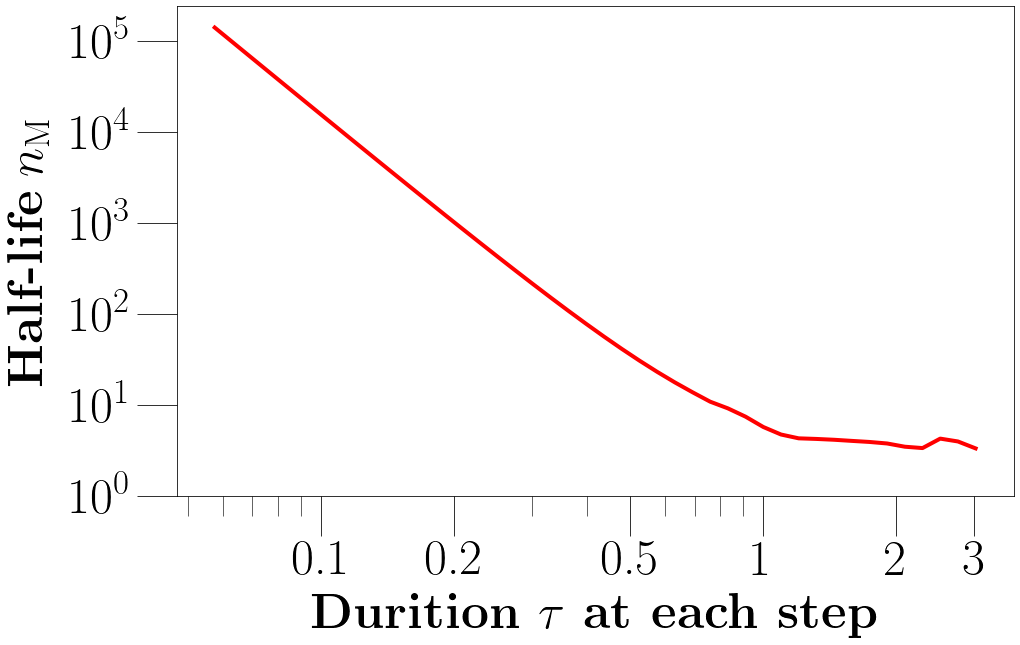

In [30]:
path = '/NISQRC/Data/'
filename = 'half_life_list_varytau.npy'

τ_list = np.logspace(-2, 2, 101)
data = np.load(path + filename)
half_life_list = np.array(data)

Xticks = [0.1, 0.2, 0.5, 1, 2, 3]

fig, axes = plt.subplots(1, 1, figsize=(15, 9))
ax = axes
ax.plot(τ_list[19:63], np.array(half_life_list)[19:63], color='red')
ax.set_ylabel(r'\textbf{Half-life} $n_{\mathrm{M}}$', labelpad=20)
ax.set_xlabel(r'\textbf{Durition $\tau$ at each step}', labelpad=10)
# ax.set_ylim([1e0, 1e6])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(Xticks)
ax.set_xticklabels(Xticks)
ax.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5])

# ax.spines[['bottom', 'top', 'right', 'left']].set_color('gray')